In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Activation,  LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
path = '/content/drive/MyDrive/dataset'

In [21]:
NUM_CLASSES = 2
ikan_classes = ["Segar", "Tidak Segar"]

names = []
nums = []
data = {'Name of class':[], 'Number of samples':[]}

for i in os.listdir(path+'/train'):
    if i == 'fresh':
        names.append('Segar')
    elif i == 'non-fresh':
        names.append('Tidak Segar')
    nums.append(len(os.listdir(path+'/train/'+i)))

data['Name of class'] += names
data['Number of samples'] += nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,Segar,35
1,Tidak Segar,35


<Axes: xlabel='Name of class', ylabel='Number of samples'>

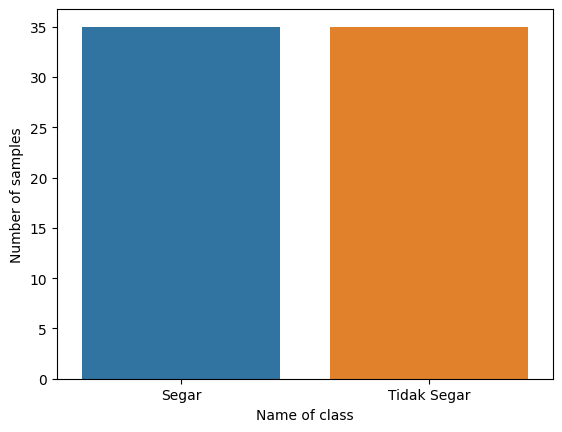

In [22]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

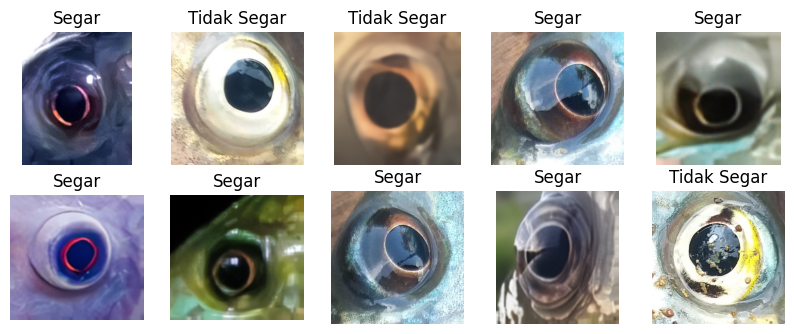

In [23]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(10, 10))
for x in range(10):
    i = random.randint(0, 1)  # getting the class (0 for Segar, 1 for Tidak Segar)
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0, len(images)-1)  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(ikan_classes[i])
    plt.axis("off")

plt.show()


# 3. Preparing the data

In [24]:
# Membuat objek ImageDataGenerator dengan konfigurasi augmentasi citra
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,               # Skala ulang intensitas piksel ke rentang 0-1
    horizontal_flip=True,         # Mengaktifkan flipping horizontal (memutar citra secara horizontal)
    vertical_flip=True,           # Mengaktifkan flipping vertikal (memutar citra secara vertikal)
    rotation_range=1,            # Rentang rotasi citra (dalam derajat)
    zoom_range=0.1,              # Rentang perbesaran citra
    width_shift_range=0.1,       # Rentang pergeseran horizontal citra
    height_shift_range=0.1,      # Rentang pergeseran vertikal citra
    shear_range=0.1,             # Rentang pergeseran sudut citra
    fill_mode="nearest",          # Metode pengisian piksel yang hilang saat augmentasi
    validation_split=0.2          # Pembagian data validasi sebesar 30% dari total data
)

In [25]:
# Mendefinisikan dataset pelatihan dan validasi menggunakan flow_from_directory
train_ds = image_datagen.flow_from_directory(
    path+'/train',
    target_size=(150, 150),
    batch_size=40,
    class_mode='categorical',
    subset='training'
)

val_ds = image_datagen.flow_from_directory(
    path+'/train',
    target_size=(150, 150),
    batch_size=40,
    class_mode='categorical',
    subset='validation'
)

Found 56 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


Found 56 images belonging to 2 classes.


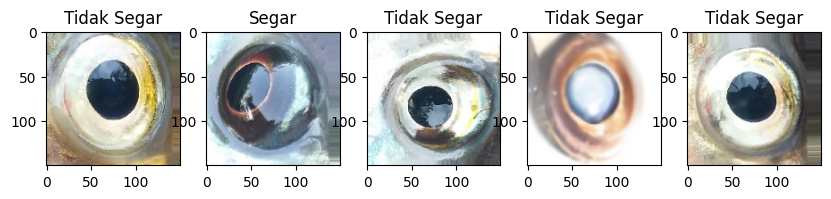

In [26]:
import matplotlib.pyplot as plt

# Mengambil citra-citra dari dataset menggunakan metode flow_from_directory
images, labels = next(image_datagen.flow_from_directory(
    path+'/train',
    target_size=(150, 150),
    batch_size=5,    # Jumlah citra yang akan diambil
    class_mode='categorical',
    subset='training'
))

# Mengonversi labels menjadi nama kelas
class_names = np.array(ikan_classes)
labels = np.argmax(labels, axis=1)
class_labels = class_names[labels]

# Menampilkan gambar-gambar dalam batch
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(class_labels[i])
plt.show()


# 4. Building the model

In [27]:
def make_model():
    ModelVGG16 = tf.keras.models.Sequential([
        tf.keras.applications.VGG16(input_shape=(150,150 , 3),
                                    include_top=False,
                                    pooling='max',
                                    weights='imagenet'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return ModelVGG16

In [28]:
model = make_model()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0008, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 14,780,610
Trainable params: 14,780,610
Non-trainable params: 0
_________________________________________________________________


# 5. Training and evaluating

In [29]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 15)

Epoch 1/15
2/2 [==============================] - 5s 860ms/step - loss: 1.0148 - accuracy: 0.5000 - val_loss: 0.8727 - val_accuracy: 0.5000
Epoch 2/15
2/2 [==============================] - 1s 309ms/step - loss: 0.8152 - accuracy: 0.5357 - val_loss: 0.7418 - val_accuracy: 0.5000
Epoch 3/15
2/2 [==============================] - 1s 782ms/step - loss: 0.7409 - accuracy: 0.5179 - val_loss: 0.7388 - val_accuracy: 0.5000
Epoch 4/15
2/2 [==============================] - 1s 778ms/step - loss: 0.8036 - accuracy: 0.4643 - val_loss: 0.8013 - val_accuracy: 0.5000
Epoch 5/15
2/2 [==============================] - 1s 312ms/step - loss: 0.7580 - accuracy: 0.5714 - val_loss: 0.7310 - val_accuracy: 0.5000
Epoch 6/15
2/2 [==============================] - 1s 791ms/step - loss: 0.6354 - accuracy: 0.6607 - val_loss: 0.6500 - val_accuracy: 0.5714
Epoch 7/15
2/2 [==============================] - 1s 351ms/step - loss: 0.6146 - accuracy: 0.6429 - val_loss: 0.5886 - val_accuracy: 0.7857
Epoch 8/15
2/2 [====

1/1 [==============================] - 0s 213ms/step - loss: 0.3344 - accuracy: 0.8571


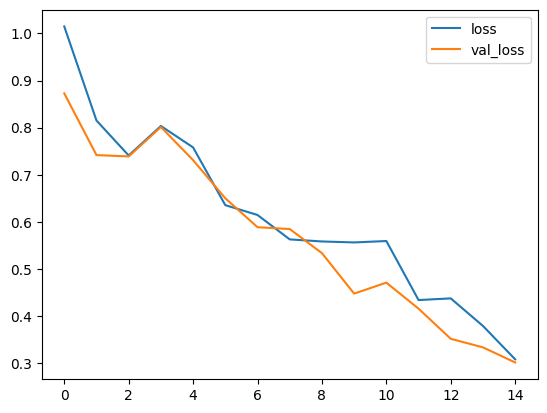

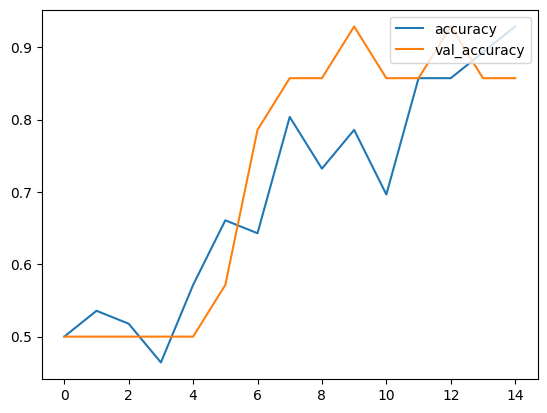

In [30]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [46]:
from sklearn.metrics import classification_report

# Get the predictions for the validation dataset
y_pred = model.predict(val_ds)

# Convert the predictions into class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels into class labels
y_true_classes = val_ds.classes

# Get the class names
class_names = list(val_ds.class_indices.keys())

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Print the classification report
print(report)

1/1 [==============================] - 0s 167ms/step
              precision    recall  f1-score   support

       fresh       0.62      0.71      0.67         7
   non-fresh       0.67      0.57      0.62         7

    accuracy                           0.64        14
   macro avg       0.65      0.64      0.64        14
weighted avg       0.65      0.64      0.64        14



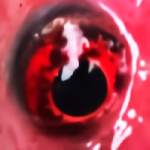

In [57]:
# Load the imageg
image_path = '/content/drive/MyDrive/dataset/train/non-fresh/non-fresh (4).jpg'
img = Image.open(image_path)
load_img(image_path,target_size=(150,150))

In [58]:
150# Resize the image to match the model's input shape
resized_img = img.resize((150, 150))

# Preprocess the image
input_image = np.array(resized_img) / 255.0
input_image = np.expand_dims(input_image, axis=0)

# Make the prediction
prediction = model.predict(input_image)
predicted_class = ikan_classes[np.argmax(prediction)]

print("Prediksi kelas:", predicted_class)


1/1 [==============================] - 0s 27ms/step
Prediksi kelas: Tidak Segar


# 6. Save Model


In [34]:
# Simpan model
# model.save('fish_classification_model_vgg16.h5')